In [1]:
%matplotlib inline

In [2]:
import numpy as np
from numpy import log

from scipy import linalg
from scipy import sparse
from scipy.sparse import csr_matrix

import pandas as pd

import sklearn.metrics.pairwise as knl
from sklearn import datasets
from sklearn.manifold import Isomap
from sklearn.neighbors import kneighbors_graph, radius_neighbors_graph
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import time
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from matplotlib import cm
plt.rcParams['figure.figsize'] = [9,5] #globally set figure size
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'small',
         'axes.titlesize':'small',
         'xtick.labelsize':8,
         'ytick.labelsize':8}
plt.rcParams.update(params)

from mpl_toolkits.mplot3d import Axes3D

import tadasets

from ripser import ripser
from persim import plot_diagrams

from tqdm.notebook import tqdm, trange

/home/ag16115/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [3]:
np.random.seed(123)

## Links to datasets

* need trainingData.csv from http://archive.ics.uci.edu/ml/datasets/UJIIndoorLoc


## Wi-fi localisation example

In [4]:
#assess performance of knn regression as a function of embedding dimension

covs_and_resp = np.loadtxt('data/trainingData.csv', delimiter=',',skiprows=1, dtype=float )
#first 520 columns are wifi data
#remaining 9 cols are LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
np.random.seed(123)
np.random.shuffle(covs_and_resp)

col_resp = np.array([520, 521],dtype=int) #column of the responses of interest
num_response = col_resp.size

#full data set has n=19937 rows
response_mat = covs_and_resp[0:2000,col_resp]
covariates_mat = covs_and_resp[0:2000,0:520]

(n,p) = covariates_mat.shape
print(n,p)

#centering
covariates_mat = covariates_mat - covariates_mat.mean(axis=0)

r = np.min((n,p))-1

U, s, Vh = sparse.linalg.svds(covariates_mat,k=r)
idx = np.argsort(s)
idx = np.flip(idx)
U = U[:,idx]
s_loc = s[idx]
Vh = Vh[idx,:]
zeta =  U[:,0:r] @ np.diag(s_loc[0:r]) /p**0.5



2000 520


<StemContainer object of 3 artists>

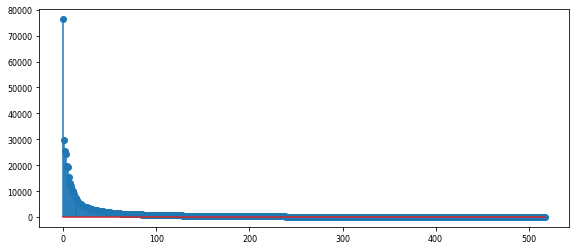

In [5]:
fig = plt.figure(figsize=(9.5,4))

ax = fig.add_subplot(111)
ax.stem(s_loc[0:r]**2/n)

In [6]:
n_reps = 200 #number of random test/train splits

neigh = KNeighborsRegressor(n_neighbors=5)
r_max_plot = r
r_arr_loc = np.arange(1,r_max_plot+1, step=5) #range of embedding dimensions to consider when doing regression
r_arr_count = r_arr_loc.shape[0]

scores_loc = np.zeros((n_reps,r_arr_count,num_response))


                  
for i_rep in trange(n_reps):
    zeta_train, zeta_test, response_train, response_test = train_test_split(zeta, response_mat, test_size=0.3)

    for q in range(r_arr_count):
        #print(i_rep,q)
        neigh.fit(zeta_train[:,0:r_arr_loc[q]], response_train)
        response_pred = neigh.predict(zeta_test[:,0:r_arr_loc[q]])
        scores_loc[i_rep,q,:] = r2_score(response_test,response_pred,multioutput='raw_values')


In [7]:
# np.savetxt('data/s_loc.dat', s_loc)
# np.savetxt('data/scores_loc_long.dat', scores_loc[:,:,0])
# np.savetxt('data/scores_loc_lat.dat', scores_loc[:,:,1])
# np.savetxt('data/r_arr_loc.dat', r_arr_loc)

In [8]:
print(scores_loc.shape)
print(r_arr_loc.shape)

(200, 104, 2)
(104,)


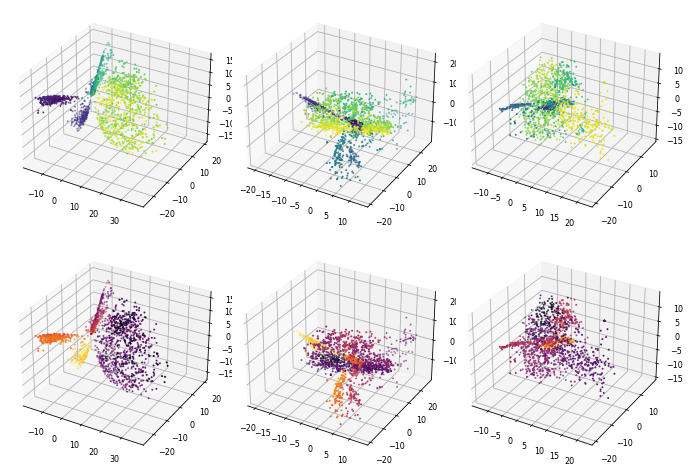

In [9]:
fig = plt.figure(figsize=(9.5,7))

colour = response_mat[:,0] #choose one of the response variables to colour PC scores

my_cmap = 'viridis'

ax = fig.add_subplot(231, projection='3d')
ax.scatter(zeta[:,0], zeta[:,1], zeta[:,2],  marker='o', s=1, c=colour, cmap=my_cmap) #c=color,


ax = fig.add_subplot(232, projection='3d')
ax.scatter(zeta[:,3], zeta[:,4], zeta[:,5], marker='o',  s=1, c=colour, cmap=my_cmap)

ax = fig.add_subplot(233, projection='3d')
ax.scatter(zeta[:,6], zeta[:,7], zeta[:,8], marker='o', s=1, c=colour, cmap=my_cmap)

colour = response_mat[:,1]
my_cmap = 'inferno'

ax = fig.add_subplot(234, projection='3d')
ax.scatter(zeta[:,0], zeta[:,1], zeta[:,2],  marker='o', s=1, c=colour, cmap=my_cmap)

ax = fig.add_subplot(235, projection='3d')
ax.scatter(zeta[:,3], zeta[:,4], zeta[:,5], marker='o',  s=1, c=colour, cmap=my_cmap)

ax = fig.add_subplot(236, projection='3d')
ax.scatter(zeta[:,6], zeta[:,7], zeta[:,8], marker='o', s=1, c=colour, cmap=my_cmap)

#fig.colorbar(im,ax=ax)

fig.tight_layout()

In [10]:
#t-SNE to reduce to 3 dimensions for visualization
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=1000)
tsne_results = tsne.fit_transform(zeta[:,0:25])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/home/ag16115/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ag16115/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.176s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 10.359436
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.014000
[t-SNE] KL divergence after 1000 iterations: 0.450456
t-SNE done! Time elapsed: 8.868998050689697 seconds


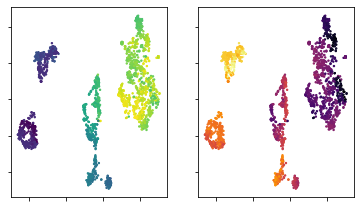

In [11]:
fig = plt.figure(figsize=(9.5,3.5))
ax = fig.add_subplot(131)
ax.scatter(tsne_results[:,0],tsne_results[:,1],marker='o',c=response_mat[:,0], s=2, cmap='viridis')
ax.tick_params(labelbottom=False, labelleft=False)
ax.dist = 8
ax.elev = 10

ax = fig.add_subplot(132)
ax.scatter(tsne_results[:,0],tsne_results[:,1],marker='o',c=response_mat[:,1], s=2, cmap='inferno')
ax.tick_params(labelbottom=False, labelleft=False)
ax.dist = 8
ax.elev = 10

## CT scan example

In [87]:
#the full data set has 50k+ rows
response_mat = np.loadtxt('data/CT_response_mat.dat')
covariates_mat = np.loadtxt('data/CT_covariates_mat.dat')

(n,p) = covariates_mat.shape
print(n,p)

#centering
covariates_mat = covariates_mat - covariates_mat.mean(axis=0)

r = np.min((n,p))-1

#do the joint embedding

U, s, Vh = sparse.linalg.svds(covariates_mat,k=r)
idx = np.argsort(s)
idx = np.flip(idx)
U = U[:,idx]
s_CT = s[idx]
Vh = Vh[idx,:]
zeta =  U[:,0:r] @ np.diag(s_CT[0:r]) /p**0.5

2500 384


<StemContainer object of 3 artists>

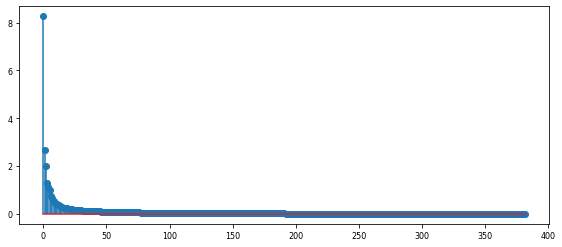

In [88]:
fig = plt.figure(figsize=(9.5,4))
ax = fig.add_subplot(111)
ax.stem(s_CT[0:r]**2/n)

In [14]:
n_reps = 200 #number of random test/train splits

neigh = KNeighborsRegressor(n_neighbors=5)
r_max_plot = r
r_arr_CT = np.arange(1,r_max_plot, step=5) #range of embedding dimensions to consider when doing regression
r_arr_count = r_arr_CT.shape[0]

scores_CT = np.zeros((n_reps,r_arr_count,num_response))

                  
for i_rep in trange(n_reps):
    zeta_train, zeta_test, response_train, response_test = train_test_split(zeta, response_mat, test_size=0.3)

    for q in range(r_arr_count):
        #print(i_rep,q)
        neigh.fit(zeta_train[:,0:r_arr_CT[q]], response_train)
        response_pred = neigh.predict(zeta_test[:,0:r_arr_CT[q]])
        scores_CT[i_rep,q,:] = r2_score(response_test,response_pred,multioutput='raw_values')

In [15]:
# np.savetxt('data/s_CT.dat', s_CT)
# np.savetxt('data/scores_CT.dat', scores_CT[:,:,0])
# np.savetxt('data/r_arr_CT.dat', r_arr_CT)

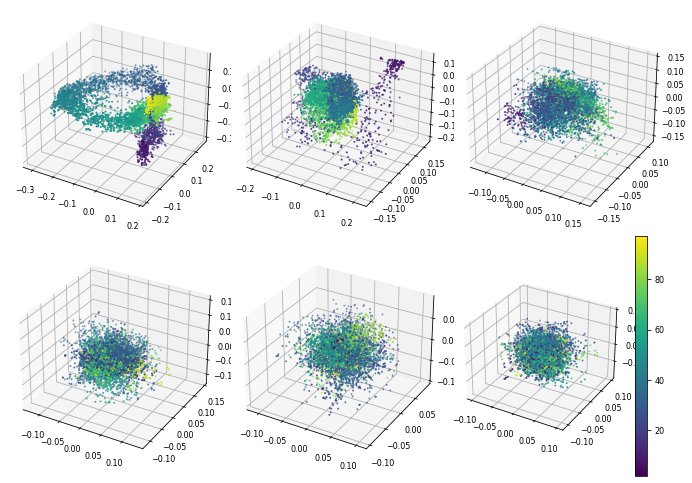

In [16]:
fig = plt.figure(figsize=(9.5,7))

colour = response_mat[:,0] #choose one of the response variables to colour PC scores

my_cmap = 'viridis'

ax = fig.add_subplot(231, projection='3d')
ax.scatter(zeta[:,0], zeta[:,1], zeta[:,2],  marker='o', s=1, c=colour, cmap=my_cmap) #c=color,


ax = fig.add_subplot(232, projection='3d')
ax.scatter(zeta[:,3], zeta[:,4], zeta[:,5], marker='o',  s=1, c=colour, cmap=my_cmap)

ax = fig.add_subplot(233, projection='3d')
ax.scatter(zeta[:,6], zeta[:,7], zeta[:,8], marker='o', s=1, c=colour, cmap=my_cmap)

ax = fig.add_subplot(234, projection='3d')
ax.scatter(zeta[:,9], zeta[:,10], zeta[:,11],  marker='o', s=1, c=colour, cmap=my_cmap) #c=color,


ax = fig.add_subplot(235, projection='3d')
ax.scatter(zeta[:,12], zeta[:,13], zeta[:,14], marker='o',  s=1, c=colour, cmap=my_cmap)

ax = fig.add_subplot(236, projection='3d')
im = ax.scatter(zeta[:,15], zeta[:,16], zeta[:,17], marker='o', s=1, c=colour, cmap=my_cmap)

fig.colorbar(im,ax=ax)

fig.tight_layout()

## MNIST digits

In [17]:
covs_and_resp = np.loadtxt('data/mnist_test.csv', delimiter=',',skiprows=1, dtype=float )
# col 0  = class label 0-9
# col 1-784 pixel intensities
np.random.seed(456)
np.random.shuffle(covs_and_resp)

col_resp = np.array([0],dtype=int) #column of the responses of interest
num_response = col_resp.size

#the full data set has 50k+ rows
response_mat = covs_and_resp[0:2000,col_resp]
covariates_mat = covs_and_resp[0:2000,1:]

(n,p) = covariates_mat.shape
print(n,p)

2000 784


In [18]:
r = np.min((n,p))-1

#do the joint embedding

covariates_mat = covariates_mat - covariates_mat.mean(axis=0)

U, s, Vh = sparse.linalg.svds(covariates_mat,k=r)
idx = np.argsort(s)
idx = np.flip(idx)
U = U[:,idx]
s_MNIST = s[idx]
Vh = Vh[idx,:]
zeta =  U[:,0:r] @ np.diag(s_MNIST[0:r]) /p**0.5

<StemContainer object of 3 artists>

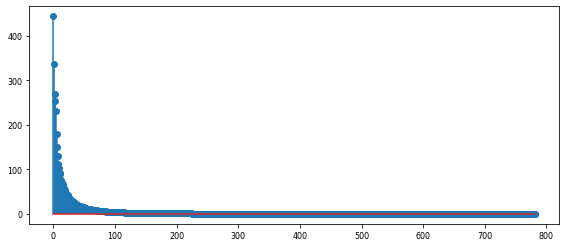

In [19]:
fig = plt.figure(figsize=(9.5,4))
ax = fig.add_subplot(111)
ax.stem(s_MNIST[0:r]**2/(n*p))

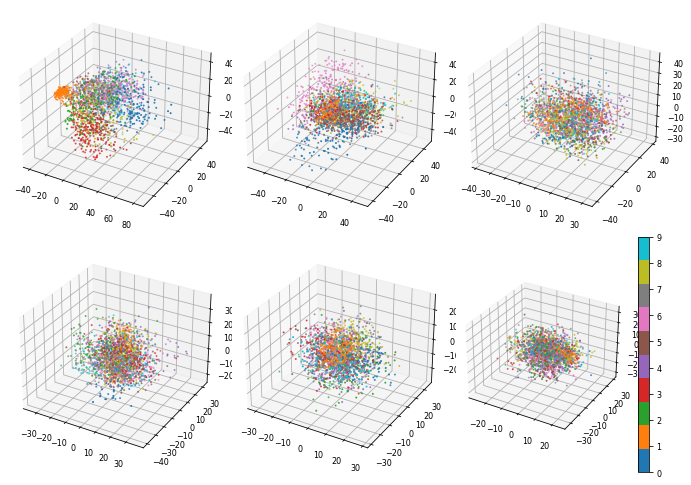

In [20]:
fig = plt.figure(figsize=(9.5,7))

colour = response_mat #choose one of the response variables to colour PC scores

my_cmap = 'tab10'

ax = fig.add_subplot(231, projection='3d')
ax.scatter(zeta[:,0], zeta[:,1], zeta[:,2],  marker='o', s=1, c=colour, cmap=my_cmap) #c=color,


ax = fig.add_subplot(232, projection='3d')
ax.scatter(zeta[:,3], zeta[:,4], zeta[:,5], marker='o',  s=1, c=colour, cmap=my_cmap)

ax = fig.add_subplot(233, projection='3d')
ax.scatter(zeta[:,6], zeta[:,7], zeta[:,8], marker='o', s=1, c=colour, cmap=my_cmap)

ax = fig.add_subplot(234, projection='3d')
ax.scatter(zeta[:,9], zeta[:,10], zeta[:,11],  marker='o', s=1, c=colour, cmap=my_cmap) #c=color,


ax = fig.add_subplot(235, projection='3d')
ax.scatter(zeta[:,12], zeta[:,13], zeta[:,14], marker='o',  s=1, c=colour, cmap=my_cmap)

ax = fig.add_subplot(236, projection='3d')
im = ax.scatter(zeta[:,15], zeta[:,16], zeta[:,17], marker='o', s=1, c=colour, cmap=my_cmap)

fig.colorbar(im,ax=ax)

fig.tight_layout()

In [21]:
n_reps = 200 #number of random test/train splits

neigh = KNeighborsClassifier(n_neighbors=5)
r_max_plot = r
r_arr_MNIST = np.arange(1,r_max_plot, step=5) #range of embedding dimensions to consider when doing regression
r_arr_count = r_arr_MNIST.shape[0]

scores_MNIST = np.zeros((n_reps,r_arr_count))
response_mat = np.ravel(response_mat)
                  
for i_rep in trange(n_reps):
    #print(i_rep)
    zeta_train, zeta_test, response_train, response_test = train_test_split(zeta, response_mat, test_size=0.3)

    for q in range(r_arr_count):
        #print(i_rep,q)
        neigh.fit(zeta_train[:,0:r_arr_MNIST[q]], response_train)
        scores_MNIST[i_rep,q] = neigh.score(zeta_test[:,0:r_arr_MNIST[q]],response_test)

In [22]:
# np.savetxt('data/s_MNIST.dat', s_MNIST)
# np.savetxt('data/scores_MNIST.dat', scores_MNIST)
# np.savetxt('data/r_arr_MNIST.dat', r_arr_MNIST)

In [23]:
#t-SNE to reduce to 2 dimensions for visualization

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=1000)
tsne_results = tsne.fit_transform(zeta[:,0:21])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...


/home/ag16115/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ag16115/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 2000 samples in 0.135s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 15.906131
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.418854
[t-SNE] KL divergence after 1000 iterations: 1.156747
t-SNE done! Time elapsed: 5.3815696239471436 seconds


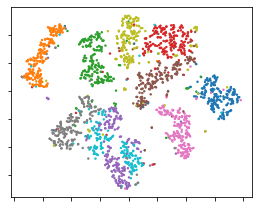

In [24]:
fig = plt.figure(figsize=(9.5,3.5))
ax = fig.add_subplot(121)
ax.scatter(tsne_results[:,0],tsne_results[:,1],marker='o',c=response_mat, s=2, cmap='tab10')
ax.tick_params(labelbottom=False, labelleft=False)
ax.dist = 8
ax.elev = 10

## UCI Dorothea drug discovery

In [26]:
#covariates are sparse binary - input file consistst of integers specifying locations of ones for each data point

#get the total number of nonzero entries in the covariates matrix
n = 0
nnz = 0
with open('data/dorothea_train.data') as f:
    for line in f:
        n += 1
        nnz = nnz + len(line.split())
        
    print(n)
    print(nnz)

#arrays to contain row/col coords of nonzero entries
row_ind = np.empty(nnz,dtype=int)
col_ind = np.empty(nnz,dtype=int)
line_count = -1
nnz = 0
#print(line_count)
#print(nnz)

with open('data/dorothea_train.data') as f:
    for line in f:
        line_count +=1
        nnz_inc = len(line.split()) 
        
        #print(line_count)
        #print(nnz_inc)
        
        row_ind[nnz : nnz+nnz_inc] = line_count
        col_ind[nnz : nnz+nnz_inc] = np.array(line.split(),dtype=int)
        nnz = nnz + nnz_inc

col_ind=col_ind-col_ind.min()      

with open('data/dorothea_train.labels') as f:
    response =  np.array(f.readlines(),dtype=int)

covariates_mat = csr_matrix((np.ones(nnz), (row_ind, col_ind)))

(n,p) = covariates_mat.shape
print(n,p)

800
727760
800 100000


In [27]:
r = np.min((n,p))-1

#do the joint embedding

covariates_mat = covariates_mat - covariates_mat.mean(axis=0)
U, s, Vh = sparse.linalg.svds(covariates_mat,k=r)
idx = np.argsort(s)
idx = np.flip(idx)
U = U[:,idx]
s_dot = s[idx]
Vh = Vh[idx,:]
zeta =  U[:,0:r] @ np.diag(s_dot[0:r]) /p**0.5

<StemContainer object of 3 artists>

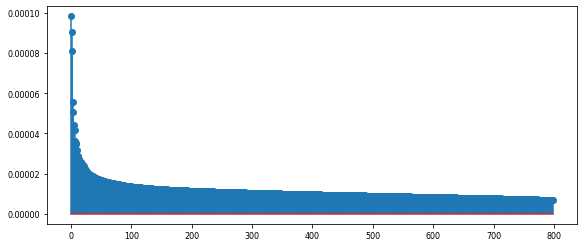

In [28]:
fig = plt.figure(figsize=(9.5,4))
ax = fig.add_subplot(111)
ax.stem(s_dot[0:r]**2/(n*p))

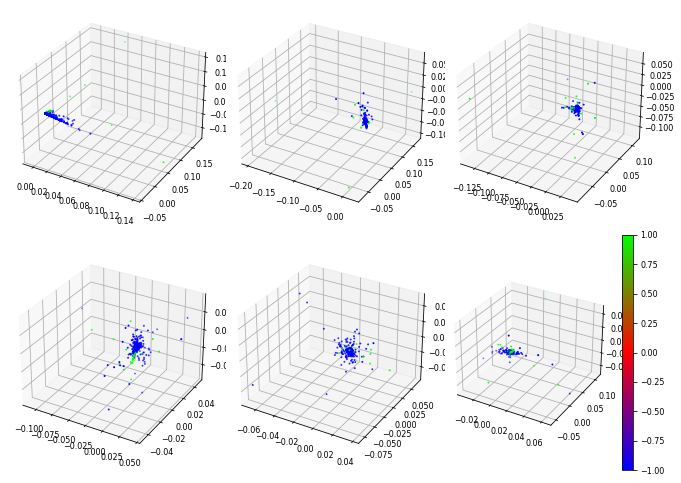

In [29]:
fig = plt.figure(figsize=(9.5,7))

colour = response #choose one of the response variables to colour PC scores

my_cmap = 'brg'

ax = fig.add_subplot(231, projection='3d')
ax.scatter(zeta[:,0], zeta[:,1], zeta[:,2],  marker='o', s=1, c=colour, cmap=my_cmap) #c=color,


ax = fig.add_subplot(232, projection='3d')
ax.scatter(zeta[:,3], zeta[:,4], zeta[:,5], marker='o',  s=1, c=colour, cmap=my_cmap)

ax = fig.add_subplot(233, projection='3d')
ax.scatter(zeta[:,6], zeta[:,7], zeta[:,8], marker='o', s=1, c=colour, cmap=my_cmap)

ax = fig.add_subplot(234, projection='3d')
ax.scatter(zeta[:,9], zeta[:,10], zeta[:,11],  marker='o', s=1, c=colour, cmap=my_cmap) #c=color,


ax = fig.add_subplot(235, projection='3d')
ax.scatter(zeta[:,12], zeta[:,13], zeta[:,14], marker='o',  s=1, c=colour, cmap=my_cmap)

ax = fig.add_subplot(236, projection='3d')
im = ax.scatter(zeta[:,15], zeta[:,16], zeta[:,17], marker='o', s=1, c=colour, cmap=my_cmap)

fig.colorbar(im,ax=ax)

fig.tight_layout()

In [30]:
n_reps = 200 #number of random test/train splits

neigh = KNeighborsClassifier(n_neighbors=5)
r_max_plot = r
r_arr_dot = np.arange(1,r_max_plot, step=5) #range of embedding dimensions to consider when doing regression
r_arr_count = r_arr_dot.shape[0]
 
scores_dot = np.zeros((n_reps,r_arr_count))

response = np.ravel(response)
                  
for i_rep in trange(n_reps):
    #print(i_rep)
    zeta_train, zeta_test, response_train, response_test = train_test_split(zeta, response, test_size=0.3)

    for q in range(r_arr_count):
        #print(i_rep,q)
        neigh.fit(zeta_train[:,0:r_arr_dot[q]], response_train)
        scores_dot[i_rep,q] = neigh.score(zeta_test[:,0:r_arr_dot[q]],response_test)

In [31]:
# np.savetxt('data/s_dot.dat', s_dot)
# np.savetxt('data/scores_dot.dat', scores_dot)
# np.savetxt('data/r_arr_dot.dat', r_arr_dot)

## Torus example

In [32]:
covariates_mat = np.loadtxt('data/torus_covariates.dat')
response_mat = np.loadtxt('data/torus_responses.dat')

num_response = 2

(n,p) = covariates_mat.shape
print(n,p)

1000 500


In [33]:
r = np.min((n,p))-1

U, s, Vh = sparse.linalg.svds(covariates_mat,k=r)
idx = np.argsort(s)
idx = np.flip(idx)
U = U[:,idx]
s_tor = s[idx]
Vh = Vh[idx,:]
zeta =  U[:,0:r] @ np.diag(s_tor[0:r]) /p**0.5

<StemContainer object of 3 artists>

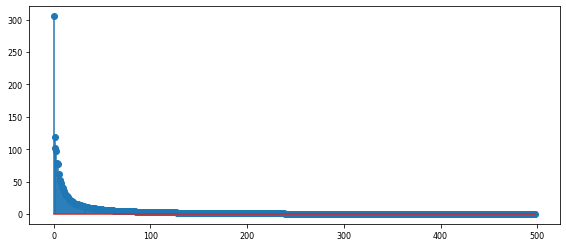

In [34]:
fig = plt.figure(figsize=(9.5,4))

ax = fig.add_subplot(111)
ax.stem(s_loc[0:r]**2/(n*p))

In [35]:
n_reps = 200 #number of random test/train splits

neigh = KNeighborsRegressor(n_neighbors=5)
r_max_plot = 100
r_arr_tor = np.arange(1,r_max_plot+1, step=1) #range of embedding dimensions to consider when doing regression
r_arr_count = r_arr_tor.shape[0]

scores_tor= np.zeros((n_reps,r_arr_count,num_response))


                  
for i_rep in trange(n_reps):
    zeta_train, zeta_test, response_train, response_test = train_test_split(zeta, response_mat, test_size=0.3)

    for q in range(r_arr_count):
        #print(i_rep,q)
        neigh.fit(zeta_train[:,0:r_arr_tor[q]], response_train)
        response_pred = neigh.predict(zeta_test[:,0:r_arr_tor[q]])
        scores_tor[i_rep,q,:] = r2_score(response_test,response_pred,multioutput='raw_values')
        

In [50]:
# np.savetxt('data/s_tor.dat', s_tor)
# np.savetxt('data/scores_tor_az.dat', scores_tor[:,:,0])
# np.savetxt('data/scores_tor_el.dat', scores_tor[:,:,1])
# np.savetxt('data/r_arr_tor.dat', r_arr_tor)

## Mixture model example

In [40]:
# scores_mm = np.loadtxt('data/scores_mm.txt')
# r_arr_mm = np.loadtxt('data/r_arr_mm.txt')
# s_mm = np.loadtxt('data/s_mm.txt')

## Figures

In [62]:
scores_loc = np.empty((200, 104, 2))
s_loc = np.loadtxt('data/s_loc.dat')
scores_loc[:,:,0] = np.loadtxt('data/scores_loc_long.dat')
scores_loc[:,:,1] = np.loadtxt('data/scores_loc_lat.dat')
r_arr_loc = np.loadtxt('data/r_arr_loc.dat')

In [71]:
scores_CT = np.empty((200, 77, 1))
scores_CT[:,:,0] = np.loadtxt('data/scores_CT.dat')
r_arr_CT = np.loadtxt('data/r_arr_CT.dat')
s_CT = np.loadtxt('data/s_CT.dat')

In [64]:
scores_MNIST = np.loadtxt('data/scores_MNIST.dat')
r_arr_MNIST = np.loadtxt('data/r_arr_MNIST.dat')
s_MNIST = np.loadtxt('data/s_MNIST.dat')

In [65]:
scores_dot = np.loadtxt('data/scores_dot.dat')
r_arr_dot = np.loadtxt('data/r_arr_dot.dat')
s_dot = np.loadtxt('data/s_dot.dat')

In [66]:
scores_tor = np.empty((200, 100, 2))
r_arr_tor = np.loadtxt('data/r_arr_tor.dat')
scores_tor[:,:,0]  = np.loadtxt('data/scores_tor_az.dat')
scores_tor[:,:,1]  = np.loadtxt('data/scores_tor_el.dat')
s_tor = np.loadtxt('data/s_tor.dat')

In [67]:
scores_mm = np.loadtxt('data/scores_mm.txt')
r_arr_mm = np.loadtxt('data/r_arr_mm.txt')
s_mm = np.loadtxt('data/s_mm.txt')

### regression

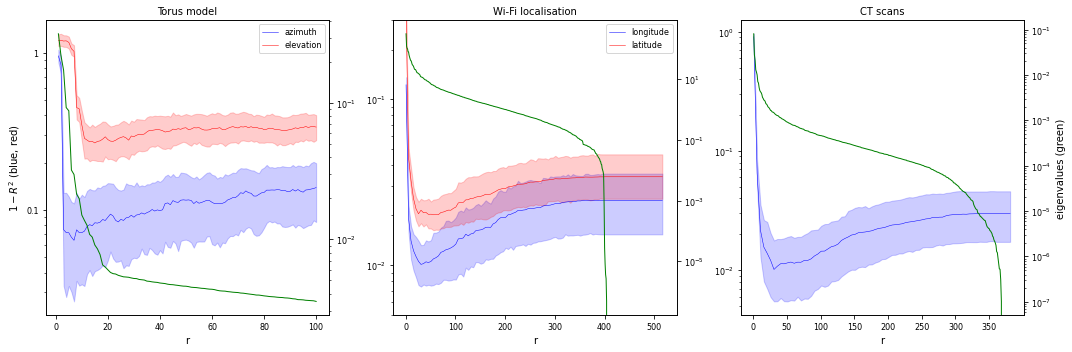

In [72]:
reg_fig = plt.figure(figsize=(15,5))
ax_tor = reg_fig.add_subplot(131)
r_max_plot = 100
ax_tor.plot(r_arr_tor, 1-scores_tor[:,:,0].mean(axis=0), 'b-', linewidth=0.5,label="azimuth")
ax_tor.fill_between(r_arr_tor, 1-np.percentile(scores_tor[:,:,0], 5, axis=0), 1-np.percentile(scores_tor[:,:,0], 95, axis=0),
                 color='blue', alpha=0.2)

ax_tor.plot(r_arr_tor, 1-scores_tor[:,:,1].mean(axis=0), 'r-', linewidth=0.5,label="elevation")
ax_tor.fill_between(r_arr_tor, 1-np.percentile(scores_tor[:,:,1], 5, axis=0), 1-np.percentile(scores_tor[:,:,1], 95, axis=0),
                 color='red', alpha=0.2)
ax_tor.set_yscale('log')
ax_tor.set_xlabel('r', fontsize=10)
ax_tor.set_xticks(range(0,r_max_plot+1,20))
ax_tor.set_yticks((0.1, 1))
ax_tor.set_yticklabels(('0.1','1'))
ax_tor.set_yticklabels([], minor=True)
ax_tor.legend(loc="upper right", fontsize=8)
ax_tor.set_ylabel('$1-R^2$ (blue, red)', fontsize=10)
ax_tor.set_title('Torus model', fontsize=10)

ax_torR = ax_tor.twinx()
ax_torR.plot(range(1,r_max_plot+1),s_tor[0:r_max_plot]**2/(n*p), 'g', linewidth=1)
ax_torR.set_yscale('log')
ax1 = reg_fig.add_subplot(132)

r_max_plot = 519
ax1.plot(r_arr_loc, 1-scores_loc[:,:,0].mean(axis=0), 'b-', linewidth=0.5,label="longitude")
ax1.fill_between(r_arr_loc, 1-np.percentile(scores_loc[:,:,0], 5, axis=0), 1-np.percentile(scores_loc[:,:,0], 95, axis=0),
                 color='blue', alpha=0.2)

ax1.plot(r_arr_loc, 1-scores_loc[:,:,1].mean(axis=0), 'r-', linewidth=0.5,label="latitude")
ax1.fill_between(r_arr_loc, 1-np.percentile(scores_loc[:,:,1], 5, axis=0), 1-np.percentile(scores_loc[:,:,1], 95, axis=0),
                 color='red', alpha=0.2)
ax1.legend(loc="upper right", fontsize=8)
ax1.set_ylim(0.005,0.3)
ax1.set_yticks((0.01, 0.1))
ax1.set_yticklabels(('0.01', '0.1'))
ax1.set_yticklabels([], minor=True)
ax1.set_yscale('log')
ax1.set_xlabel('r', fontsize=10)
ax1.set_xticks(range(0,r_max_plot+1,100))


ax1.set_title('Wi-Fi localisation', fontsize=10)

ax1R = ax1.twinx()
ax1R.plot(range(1,r_max_plot+1),s_loc[0:r_max_plot]**2/(n*p), 'g', linewidth=1)
ax1R.set_yscale('log')
r_max_plot = 383
ax2 = reg_fig.add_subplot(133)

ax2.plot(r_arr_CT, 1-scores_CT[:,:,0].mean(axis=0), 'b-', linewidth=0.5)
ax2.fill_between(r_arr_CT, 1-np.percentile(scores_CT[:,:,0], 5, axis=0), 1-np.percentile(scores_CT[:,:,0], 95, axis=0),
                 color='blue', alpha=0.2)
ax2.set_yticks((0.01, 0.1, 1))
ax2.set_yticklabels(('0.01', '0.1', '1'))
ax2.set_yticklabels([], minor=True)
ax2.set_yscale('log')
ax2.set_xlabel('r', fontsize=10)
ax2.set_xticks(range(0,r_max_plot+1,50))
ax2.set_title('CT scans', fontsize=10)

ax2R = ax2.twinx()
ax2R.plot(range(1,r_max_plot+1),s_CT[0:r_max_plot]**2/(n*p), 'g', linewidth=1)
ax2R.set_ylabel('eigenvalues (green)', fontsize=10)
ax2R.set_yscale('log')
reg_fig.tight_layout(w_pad=1)

In [57]:
# reg_fig.savefig('reg_performance.png',bbox_inches = 'tight', pad_inches=0, format='png', dpi=150)

### classification

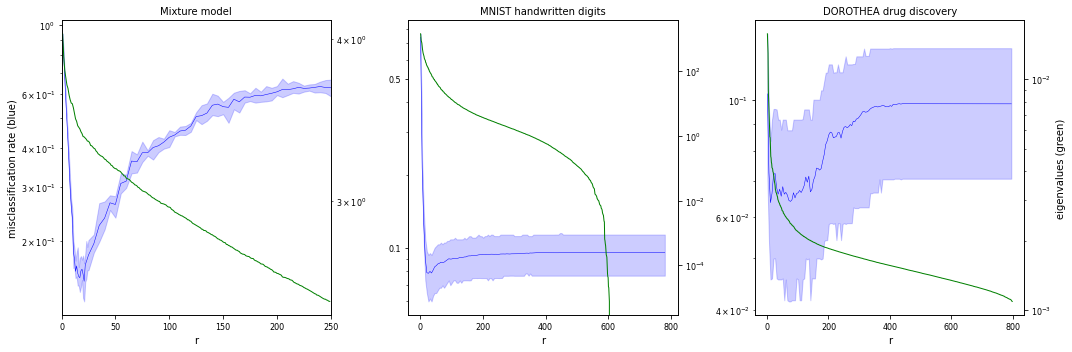

In [73]:
clas_fig = plt.figure(figsize=(15,5))
ax3 = clas_fig.add_subplot(132)
r_max_plot = 783
ax3.plot(r_arr_MNIST, 1-scores_MNIST.mean(axis=0), 'b-', linewidth=0.5)
ax3.fill_between(r_arr_MNIST, 1-np.percentile(scores_MNIST, 5, axis=0), 1-np.percentile(scores_MNIST, 95, axis=0),
                 color='blue', alpha=0.2)


ax3.set_yscale('log')
ax3.set_xlabel('r', fontsize=10)
ax3.set_title('MNIST handwritten digits', fontsize=10)
ax3.set_xticks([0,200,400,600,800])
ax3.set_yticks((0.1, 0.5))
ax3.set_yticklabels(('0.1', '0.5'))
ax3.set_yticklabels([], minor=True)
ax3R = ax3.twinx()
ax3R.plot(range(1,r_max_plot+1),s_MNIST[0:r_max_plot]**2/(n*p), 'g', linewidth=1)
ax3R.set_yscale('log')

ax4 = clas_fig.add_subplot(133)
r_max_plot = 799
ax4.plot(r_arr_dot, 1-scores_dot.mean(axis=0), 'b-', linewidth=0.5)
ax4.fill_between(r_arr_dot, 1-np.percentile(scores_dot, 5, axis=0), 1-np.percentile(scores_dot, 95, axis=0),
                 color='blue', alpha=0.2)
ax4.set_yticks((0.05, 0.1, 0.2))
ax4.set_yticklabels(('0.05','0.1', '0.2'))
ax4.set_yticklabels([], minor=True)
ax4.set_yscale('log')
ax4.set_xlabel('r', fontsize=10)
ax4.set_xticks([0,200,400,600,800])

ax4.set_title('DOROTHEA drug discovery', fontsize=10)
ax4R = ax4.twinx()
ax4R.plot(range(1,r_max_plot+1),s_dot[0:r_max_plot]**2/(n*p), 'g', linewidth=1)
ax4R.set_ylabel('eigenvalues (green)', fontsize=10)
ax4R.set_yscale('log')

ax_mm = clas_fig.add_subplot(131)
r_max_plot=249
ax_mm.plot(r_arr_mm, 1-scores_mm.mean(axis=0), 'b-', linewidth=0.5)
ax_mm.fill_between(r_arr_mm, 1-np.percentile(scores_mm, 5, axis=0), 1-np.percentile(scores_mm, 95, axis=0),
                 color='blue', alpha=0.2)
ax_mm.set_yticks([0.1, 0.5])
ax_mm.set_yticklabels(['0.1', '0.5'])
ax_mm.set_yticklabels([], minor=True)
ax_mm.set_xlim(0,250)
ax_mm.set_yscale('log')
ax_mm.set_xlabel('r', fontsize=10)
ax_mm.set_xticks([0,50,100,150,200,250])
ax_mm.set_title('Mixture model', fontsize=10)
ax_mm.set_ylabel('misclassification rate (blue)', fontsize=10)

ax_mmR = ax_mm.twinx()
ax_mmR.plot(range(1,r_max_plot+1),s_mm[0:r_max_plot]**2/(n*p), 'g', linewidth=1)
ax_mmR.set_yscale('log')
clas_fig.tight_layout(w_pad=1)

In [59]:
# clas_fig.savefig('clas_performance.png', pad_inches=0, format='png', dpi=150)